<div style="border-radius:10px; padding: 15px; background-color: #e3e6fa; text-align:left; font-size:120%; background-image: url(https://i.postimg.cc/T1gYxL48/v870-tang-35.jpg)">

<h4 align="left"><span style="font-weight:700; font-size:160%"><font color=#005f26> Face Recognition Dataset:</font></span></h4>.

<a id="import"></a>
<h2><b><span style="color:#005f26">🔶 Step 1 | </span><span style="color:#ff6200">Import Libraries</span></b></h2>

# import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from PIL import Image
import shutil
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model
import warnings
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model
import pandas as pd
import IPython.display as display
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os,random
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

<a id="load_data"></a>
<h2><b><span style="color:#005f26">🔶 Step 2 | </span><span style="color:#ff6200">Reading Data</span></b></h2>

In [2]:
dataset_path = '/kaggle/input/face-recognition-dataset/Faces/Faces'
output_path = '/kaggle/working/organized_faces'

if not os.path.exists(output_path):
    os.makedirs(output_path)

for image_name in os.listdir(dataset_path):
    image_path = os.path.join(dataset_path, image_name)

    if os.path.isfile(image_path):
        class_name = image_name.split('_')[0]
        class_dir = os.path.join(output_path, class_name)

        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        dest_path = os.path.join(class_dir, image_name)

        with open(image_path, 'rb') as src_file, open(dest_path, 'wb') as dst_file:
            shutil.copyfileobj(src_file, dst_file)

<div style="background-color: #f2faf5">
    <p style="color:navy; font-size:120%">
       ➡️ At first,how many image in each class 
    </p>
</div>

Total number of classes: 31
Class "Zac Efron": 91 images
Class "Margot Robbie": 72 images
Class "Marmik": 32 images
Class "Charlize Theron": 78 images
Class "Billie Eilish": 98 images
Class "Alia Bhatt": 79 images
Class "Claire Holt": 96 images
Class "Roger Federer": 77 images
Class "Akshay Kumar": 50 images
Class "Dwayne Johnson": 61 images
Class "Kashyap": 30 images
Class "Camila Cabello": 87 images
Class "Andy Samberg": 92 images
Class "Priyanka Chopra": 102 images
Class "Brad Pitt": 120 images
Class "Amitabh Bachchan": 74 images
Class "Natalie Portman": 105 images
Class "Henry Cavill": 106 images
Class "Tom Cruise": 58 images
Class "Ellen Degeneres": 75 images
Class "Virat Kohli": 49 images
Class "Hugh Jackman": 112 images
Class "Alexandra Daddario": 92 images
Class "Courtney Cox": 80 images
Class "Lisa Kudrow": 70 images
Class "Vijay Deverakonda": 115 images
Class "Elizabeth Olsen": 71 images
Class "Anushka Sharma": 68 images
Class "Robert Downey Jr": 113 images
Class "Hrithik Ros

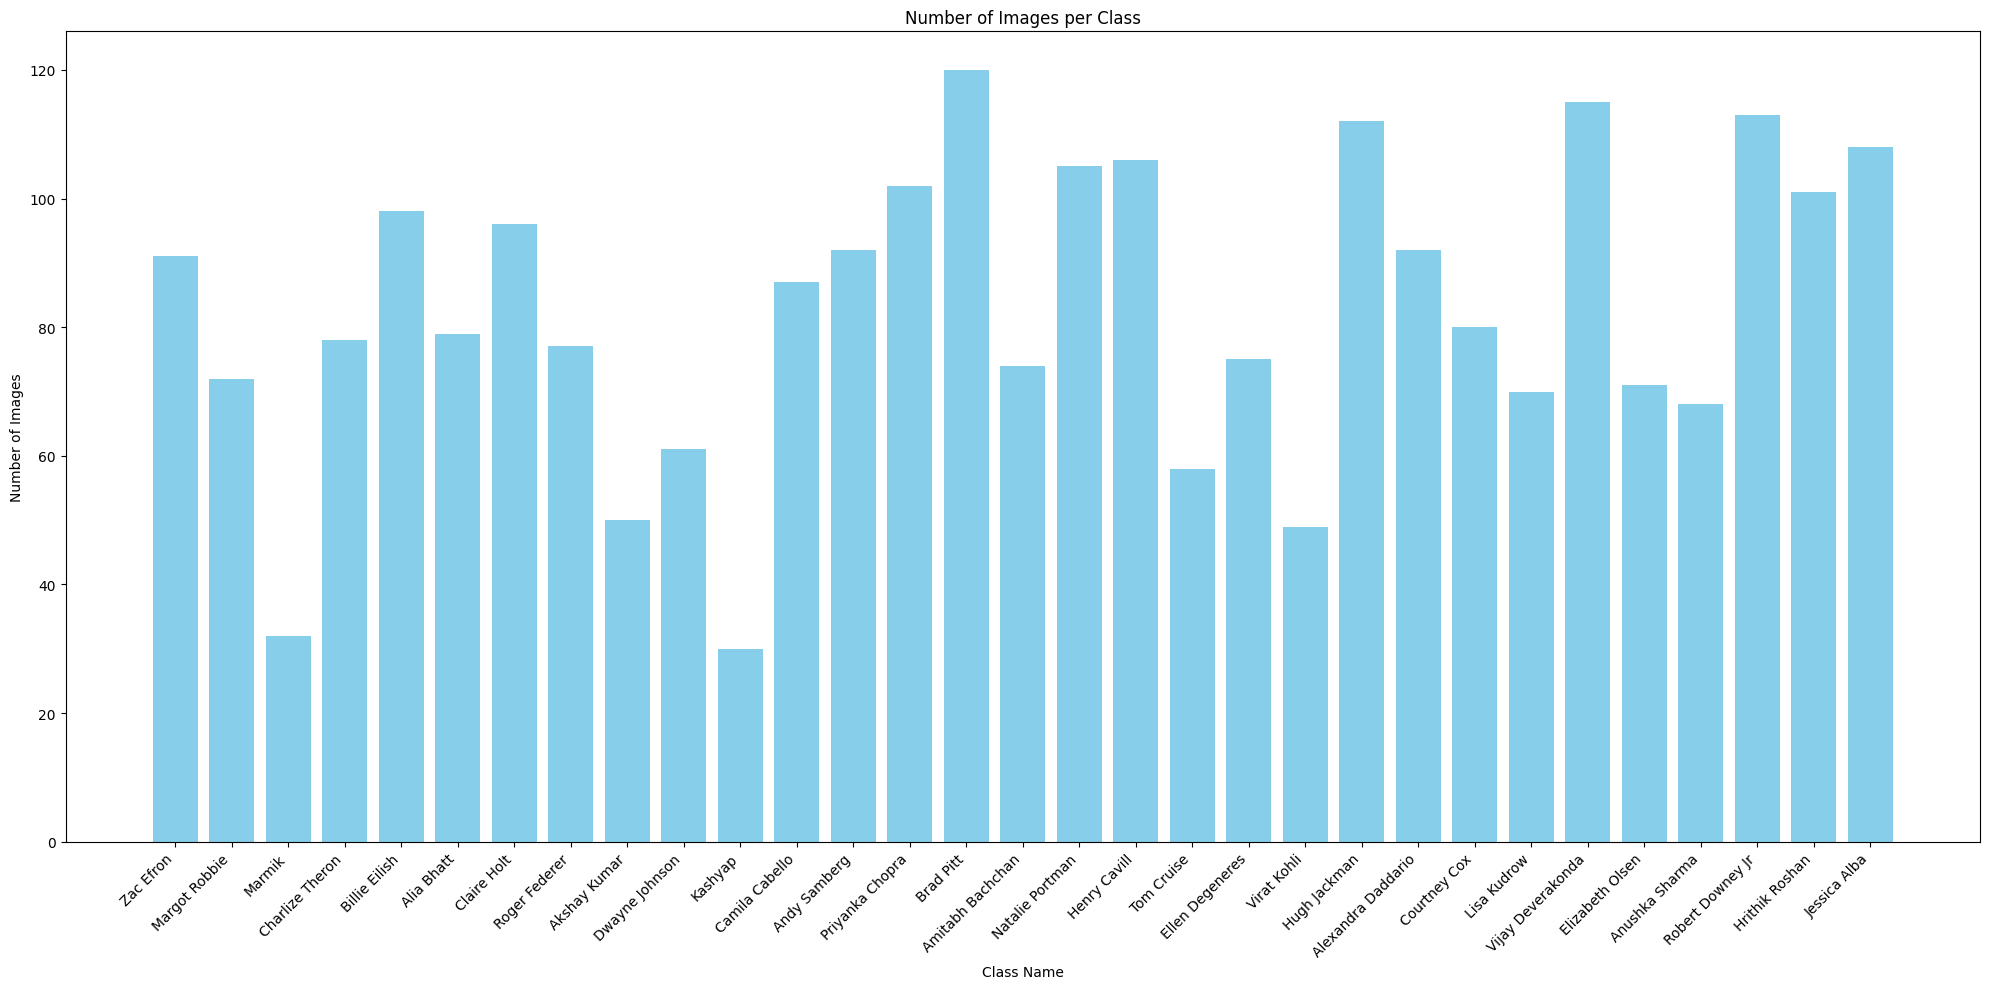

In [3]:
import os
import matplotlib.pyplot as plt


dataset_path = '/kaggle/working/organized_faces'


class_image_count = {}


for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    
    
    if os.path.isdir(class_dir):
        
        num_images = len([img for img in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, img))])
        class_image_count[class_name] = num_images

num_classes = len(class_image_count)


print(f'Total number of classes: {num_classes}')

for class_name, num_images in class_image_count.items():
    print(f'Class "{class_name}": {num_images} images')


plt.figure(figsize=(20, 10))
plt.bar(class_image_count.keys(), class_image_count.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')  
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.tight_layout()  
plt.show()

<div style="background-color: #f2faf5">
    <p style="color:navy; font-size:120%">
       ➡️ <code>opservation</code>-> there are impalance in classes .
    </p>
</div>

In [4]:
dataset_path = '/kaggle/working/organized_faces'

base_dir = '/kaggle/working/split_dataset'
train_dir = os.path.join(base_dir, 'train_dir')
test_dir = os.path.join(base_dir, 'test_dir')

for folder in [train_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)


def copy_images(image_paths, dest_folder):
    for img_path in image_paths:
        class_name = os.path.basename(os.path.dirname(img_path))
        class_folder = os.path.join(dest_folder, class_name)
        os.makedirs(class_folder, exist_ok=True)
        shutil.copy(img_path, class_folder)


def get_images_from_class(class_name):
    class_dir = os.path.join(dataset_path, class_name)
    images = []
    if os.path.isdir(class_dir):
        for entry in os.scandir(class_dir):
            if entry.is_file() and entry.name.lower().endswith(('.jpg', '.jpeg', '.png')):
                images.append((entry.path, class_name))
    return images


all_images = []
all_labels = []

# Loop through all classes and collect images and labels
for class_name in os.listdir(dataset_path):
    images_in_class = get_images_from_class(class_name)
    all_images.extend([img_path for img_path, _ in images_in_class])
    all_labels.extend([label for _, label in images_in_class])


# Split data into  train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.2, stratify=all_labels, random_state=42
)

# Copy images to respective directories
copy_images(train_images, train_dir)
copy_images(test_images, test_dir)

<a id="load_data"></a>
<h2><b><span style="color:#005f26">🔶 Step 3 | </span><span style="color:#ff6200">Show some image</span></b></h2>

Displaying some images from train_images...


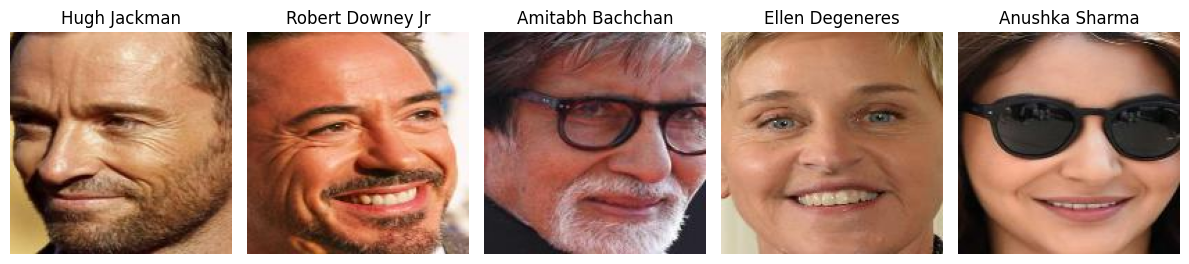

In [5]:
from PIL import Image  # Import the Image module from Pillow
import matplotlib.pyplot as plt

# Function to display some images
def display_images(image_paths, labels, num_images=5):
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        img = Image.open(image_paths[i])  # Open the image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(labels[i])  # Set the label as the title
    plt.tight_layout()
    plt.show()

# Display a few images from the virtual document set
print("Displaying some images from train_images...")
display_images(train_images, train_labels, num_images=5)


<a id="load_data"></a>
<h2><b><span style="color:#005f26">🔶 Step 4 | </span><span style="color:#ff6200">Data Augmentation</span></b></h2>

In [6]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

train_dir = '/kaggle/working/split_dataset/train_dir'
test_dir = '/kaggle/working/split_dataset/test_dir'

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,          
    width_shift_range=0.2,      
    height_shift_range=0.2,      
    shear_range=0.2,             
    zoom_range=0.2,              
    horizontal_flip=True,       
    fill_mode='nearest'          
)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(224, 224), 
    batch_size=32, 
    class_mode='categorical', 
    shuffle=True
)
test_generator = test_datagen.flow_from_directory(
    test_dir, 
    target_size=(224, 224), 
    batch_size=32, 
    class_mode='categorical', 
    shuffle=False
)

Found 2049 images belonging to 31 classes.
Found 513 images belonging to 31 classes.


<div style="background-color: #f2faf5">
    <p style="color:navy; font-size:120%">
       ➡️ <code>opservation</code>-> compute class weights .
    </p>
</div>

In [7]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

classes = np.array(train_generator.classes)


class_weights = compute_class_weight(
    class_weight='balanced',  
    classes=np.unique(classes),  
    y=classes  
)


class_weights_dict = dict(enumerate(class_weights))


print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.6524193548387096, 1: 0.8931996512641673, 2: 1.0491551459293396, 3: 1.120284308365227, 4: 0.8931996512641673, 5: 1.2240143369175627, 6: 0.847394540942928, 7: 0.688508064516129, 8: 0.9442396313364055, 9: 1.0660770031217481, 10: 0.8583996648512777, 11: 1.0327620967741935, 12: 1.348913759052008, 13: 1.1595925297113752, 14: 1.1016129032258064, 15: 0.7776091081593928, 16: 0.8160095579450418, 17: 0.7426603841971728, 18: 0.7685671417854464, 19: 2.754032258064516, 20: 1.180299539170507, 21: 1.139599555061179, 22: 2.542183622828784, 23: 0.7868663594470046, 24: 0.8160095579450418, 25: 0.7344086021505376, 26: 1.0660770031217481, 27: 1.4368863955119215, 28: 0.7184431977559608, 29: 1.694789081885856, 30: 0.9054352629253204}


<h2><b><span style="color:#005f26">🔶 Step 5 | </span><span style="color:#ff6200">Model</span></b></h2>

<div style="border-radius:10px; padding: 15px; background-color: #e3e6fa; text-align:left; font-size:120%; background-image: url(https://i.postimg.cc/T1gYxL48/v870-tang-35.jpg)">

<h4 align="left"><span style="font-weight:700; font-size:160%"><font color=#005f26> Densenet</font></span></h4>.

<img src='https://www.researchgate.net/profile/Awanit-Kumar-2/publication/362069019/figure/fig1/AS:1179153202200576@1658143439508/DenseNet121-architecture17.png'>

Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.0987 - loss: 3.9087
Epoch 1: val_accuracy improved from -inf to 0.29435, saving model to best_model.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 105s 790ms/step - accuracy: 0.0998 - loss: 3.9000 - val_accuracy: 0.2943 - val_loss: 2.8268
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.3777 - loss: 2.1479
Epoch 2: val_accuracy improved from 0.29435 to 0.46199, saving model to best_model.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 318ms/step - accuracy: 0.3784 - loss: 2.1455 - val_accuracy: 0.4620 - val_loss: 2.0011
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.5442 - loss: 1.5596
Epoch 3: val_accuracy improved from 0.46199 to 0.73879, saving model to best_model.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 313ms/step - accuracy: 0.5450 - loss: 1.5571 - val_accuracy: 0.7388 - val_loss: 0.9343
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.6992 - loss: 1.0561
Epoch 4: val_accuracy improved fr

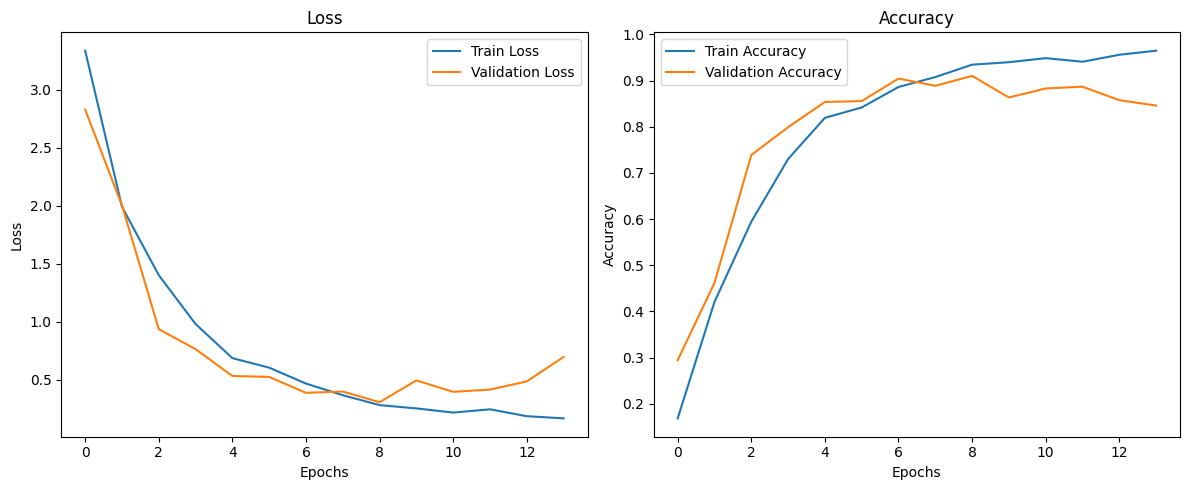

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8813 - loss: 0.5213
Test Loss: 0.6948, Test Accuracy: 0.8460


In [9]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-150]:
    layer.trainable = False


model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.25),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])


model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', 
                             save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, 
                               mode='max', verbose=1)


history = model.fit(
    train_generator,
    class_weight=class_weights_dict,
    validation_data=test_generator,
    epochs=100,
    callbacks=[checkpoint, early_stopping]
)


def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

<h2><b><span style="color:#005f26">🔶 Step 6 | </span><span style="color:#ff6200">save</span></b></h2>

In [10]:
from tensorflow.keras.models import load_model
model_path = "/kaggle/working/densenet_last.h5"
model.save(model_path)
print(f"Model saved to {model_path}")

# Load the saved model (to ensure it works properly)
loaded_model = load_model(model_path)
print("Model successfully loaded.")

Model saved to /kaggle/working/densenet_last.h5
Model successfully loaded.


<h2><b><span style="color:#005f26">🔶 Step 7 | </span><span style="color:#ff6200">evaluation</span></b></h2>

17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 468ms/step


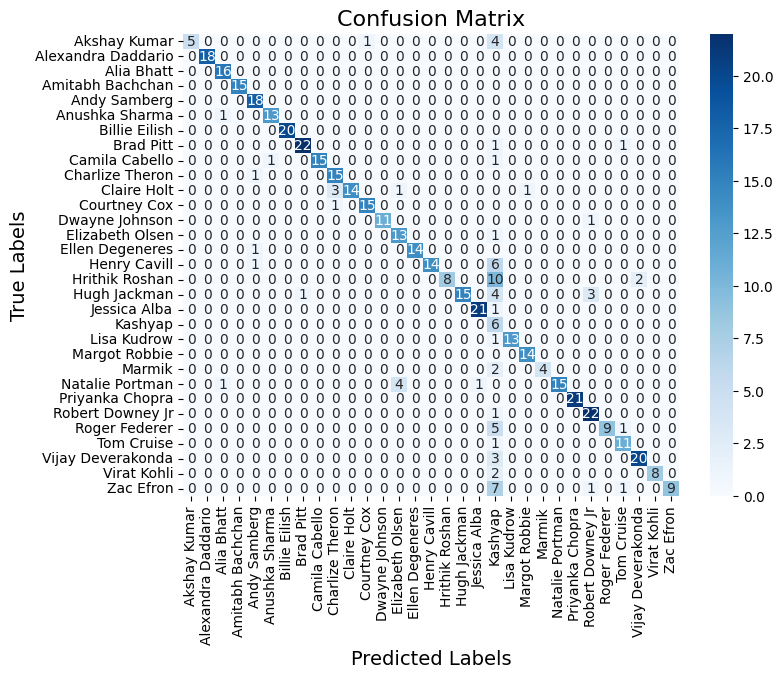

Classification Report:
                    precision    recall  f1-score   support

      Akshay Kumar       1.00      0.50      0.67        10
Alexandra Daddario       1.00      1.00      1.00        18
        Alia Bhatt       0.89      1.00      0.94        16
  Amitabh Bachchan       1.00      1.00      1.00        15
      Andy Samberg       0.86      1.00      0.92        18
    Anushka Sharma       0.93      0.93      0.93        14
     Billie Eilish       1.00      1.00      1.00        20
         Brad Pitt       0.96      0.92      0.94        24
    Camila Cabello       1.00      0.88      0.94        17
   Charlize Theron       0.79      0.94      0.86        16
       Claire Holt       1.00      0.74      0.85        19
      Courtney Cox       0.94      0.94      0.94        16
    Dwayne Johnson       1.00      0.92      0.96        12
   Elizabeth Olsen       0.72      0.93      0.81        14
   Ellen Degeneres       1.00      0.93      0.97        15
      Henry Cavi

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict classes for the validation set
y_pred_classes = model.predict(test_generator)  # Get predictions
y_pred_classes = np.argmax(y_pred_classes, axis=1)  # Convert probabilities to class indices

# Get true labels
y_true = test_generator.classes  # True class labels from the validation generator
class_labels = list(test_generator.class_indices.keys())  # Class names

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

# Classification Report
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print("Classification Report:")
print(report)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


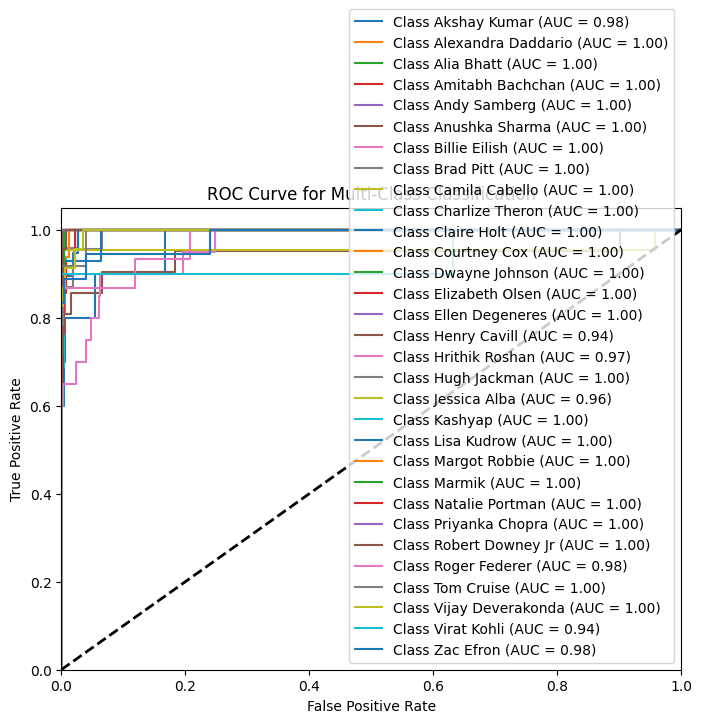

In [12]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np


y_true = test_generator.classes  
y_prob = model.predict(test_generator)  


class_names = list(test_generator.class_indices.keys())
n_classes = len(class_names)


y_true_onehot = label_binarize(y_true, classes=list(range(n_classes)))


fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2) 
plt.xlim([0.0, 1.0])

plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()

<h2><b><span style="color:#005f26">🔶 Step 7 | </span><span style="color:#ff6200">predictions</span></b></h2>

In [13]:
def predict_image(image_path):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Predict the class
    pred = model.predict(img_array, batch_size=32)
    predicted_class_index = np.argmax(pred)

    # Reverse the mapping from class indices to class names
    class_labels = {v: k for k, v in train_generator.class_indices.items()}

    # Get the actual class name from the file path
    actual_class = (image_path.split("/")[-1]).split("_")[0]

    # Display results
    print("Actual: " + actual_class)
    print("Predicted: " + f"{predicted_class_index} ({class_labels[predicted_class_index]})")



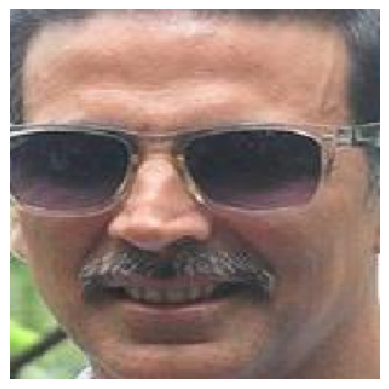

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Actual: Akshay Kumar
Predicted: 0 (Akshay Kumar)


In [31]:
predict_image("/kaggle/working/organized_faces/Akshay Kumar/Akshay Kumar_0.jpg")

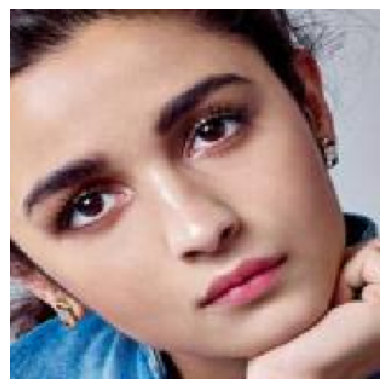

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Actual: Alia Bhatt
Predicted: 2 (Alia Bhatt)


In [33]:

predict_image("/kaggle/working/organized_faces/Alia Bhatt/Alia Bhatt_0.jpg")

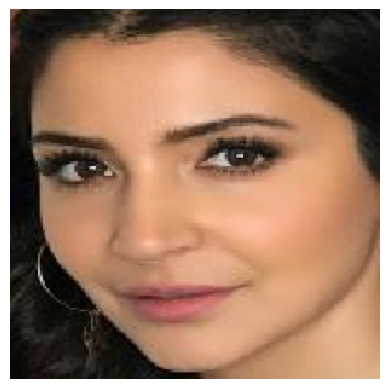

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Actual: Anushka Sharma
Predicted: 5 (Anushka Sharma)


In [37]:
predict_image("/kaggle/working/split_dataset/valid/Anushka Sharma/Anushka Sharma_16.jpg")

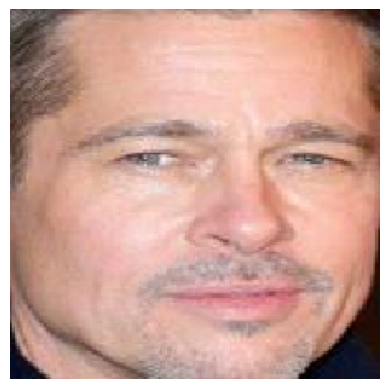

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Actual: Brad Pitt
Predicted: 7 (Brad Pitt)


In [36]:

predict_image("/kaggle/working/split_dataset/valid/Brad Pitt/Brad Pitt_63.jpg")

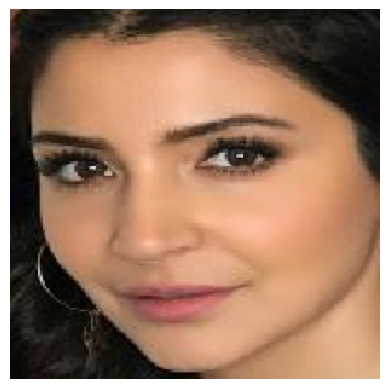

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Actual: Anushka Sharma
Predicted: 5 (Anushka Sharma)


In [35]:
predict_image("/kaggle/working/split_dataset/valid/Anushka Sharma/Anushka Sharma_16.jpg")